In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from safetensors.torch import save_model, load_model


In [2]:
figsize = 16
batch_size = 64

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


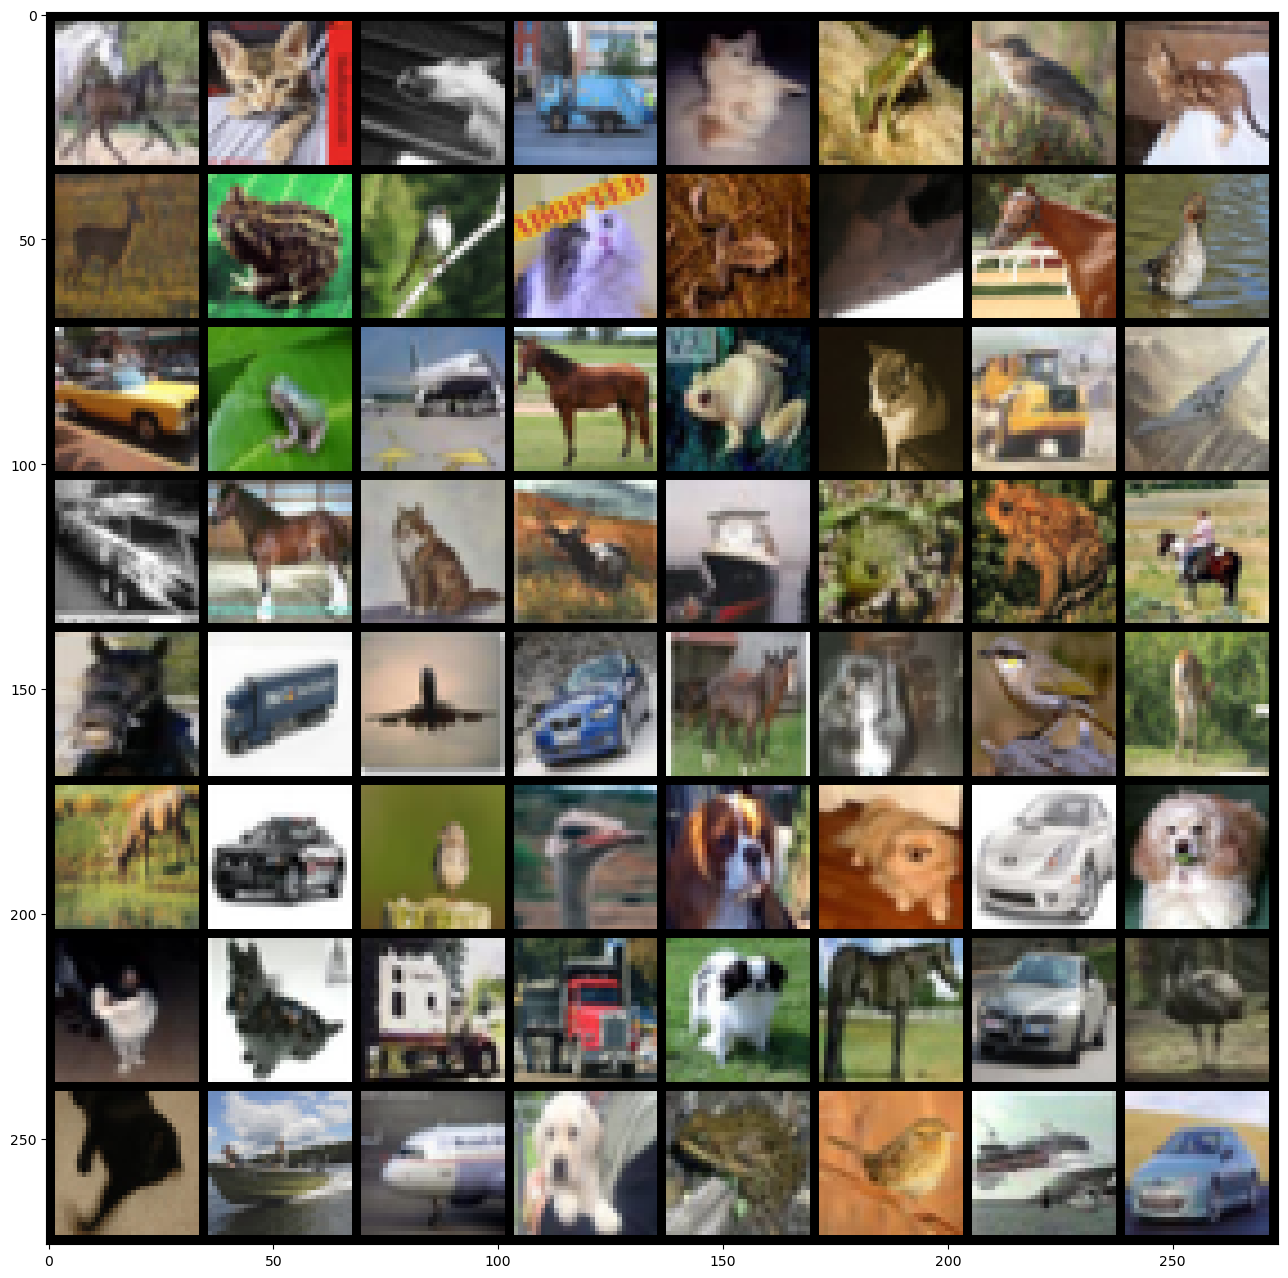

In [4]:
def imshow(img):
    plt.figure(figsize=(figsize,figsize))
    plt.imshow(img.permute(1, 2, 0).numpy())
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

In [5]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.leaky_relu1 = nn.LeakyReLU()

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.leaky_relu2 = nn.LeakyReLU()

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.leaky_relu3 = nn.LeakyReLU()

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.leaky_relu4 = nn.LeakyReLU()
        
        self.flatten = nn.Flatten(start_dim=1)
        
        self.fc1 = nn.Linear(4096, 128)
        self.bn5 = nn.BatchNorm1d(128)
        self.leaky_relu5 = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(128, 10)
        self.softmax = nn.Softmax(1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.leaky_relu1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.leaky_relu2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.leaky_relu3(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.leaky_relu4(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.bn5(x)
        x = self.leaky_relu5(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.softmax(x)
        return x


In [6]:
model = Cnn().cuda()
summary(model, (batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Cnn                                      [64, 10]                  --
├─Conv2d: 1-1                            [64, 32, 32, 32]          896
├─BatchNorm2d: 1-2                       [64, 32, 32, 32]          64
├─LeakyReLU: 1-3                         [64, 32, 32, 32]          --
├─Conv2d: 1-4                            [64, 32, 16, 16]          9,248
├─BatchNorm2d: 1-5                       [64, 32, 16, 16]          64
├─LeakyReLU: 1-6                         [64, 32, 16, 16]          --
├─Conv2d: 1-7                            [64, 64, 16, 16]          18,496
├─BatchNorm2d: 1-8                       [64, 64, 16, 16]          128
├─LeakyReLU: 1-9                         [64, 64, 16, 16]          --
├─Conv2d: 1-10                           [64, 64, 8, 8]            36,928
├─BatchNorm2d: 1-11                      [64, 64, 8, 8]            128
├─LeakyReLU: 1-12                        [64, 64, 8, 8]            --
├

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [8]:
num_epochs = 10

for epoch in range(num_epochs):
    for imgs, labels in train_loader:
        imgs, labels = imgs.to('cuda'), labels.to('cuda')    
        output = model(imgs)
        loss = criterion(output, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 1.9988
Epoch [2/10], Loss: 2.0230
Epoch [3/10], Loss: 1.8896
Epoch [4/10], Loss: 1.7520
Epoch [5/10], Loss: 1.7772
Epoch [6/10], Loss: 1.9116
Epoch [7/10], Loss: 1.7923
Epoch [8/10], Loss: 1.8158
Epoch [9/10], Loss: 1.7515
Epoch [10/10], Loss: 1.7123


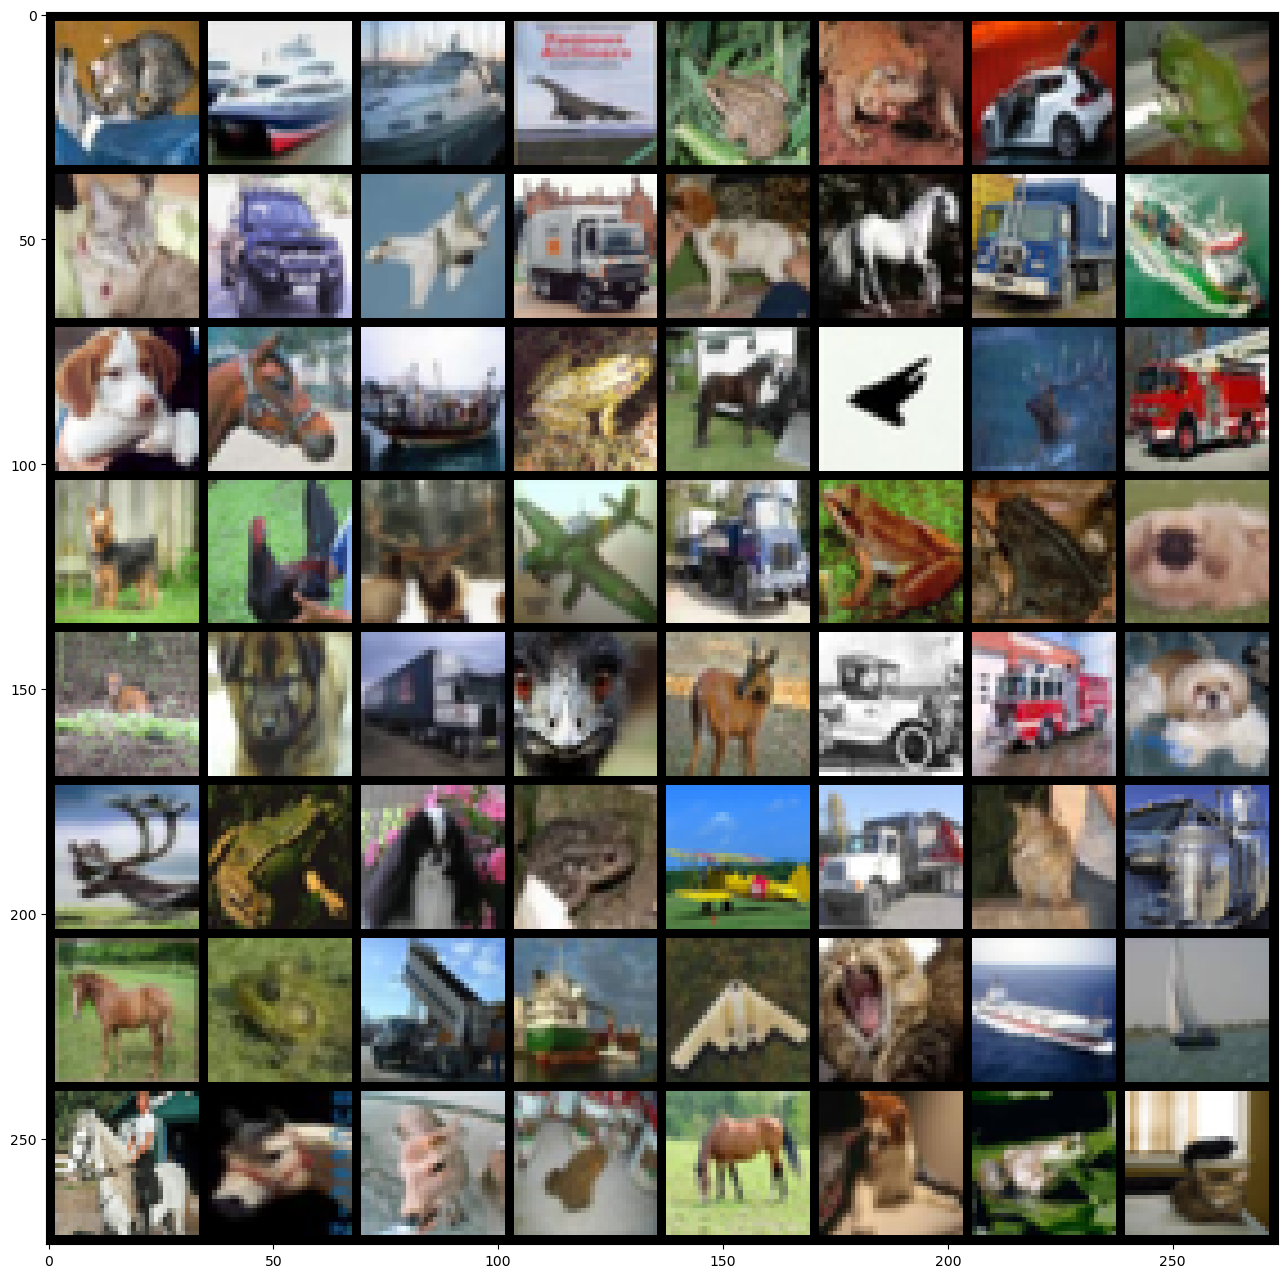

In [9]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

In [10]:
CLASSES = [
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
]
_, preds = model(images.to('cuda')).max(dim=1)

[(CLASSES[preds[i]], CLASSES[labels[i]]) for i in range(64)]


[('cat', 'cat'),
 ('ship', 'ship'),
 ('ship', 'ship'),
 ('ship', 'airplane'),
 ('deer', 'frog'),
 ('frog', 'frog'),
 ('automobile', 'automobile'),
 ('deer', 'frog'),
 ('cat', 'cat'),
 ('automobile', 'automobile'),
 ('airplane', 'airplane'),
 ('truck', 'truck'),
 ('dog', 'dog'),
 ('horse', 'horse'),
 ('truck', 'truck'),
 ('frog', 'ship'),
 ('dog', 'dog'),
 ('truck', 'horse'),
 ('ship', 'ship'),
 ('frog', 'frog'),
 ('horse', 'horse'),
 ('frog', 'airplane'),
 ('deer', 'deer'),
 ('truck', 'truck'),
 ('deer', 'dog'),
 ('frog', 'bird'),
 ('cat', 'deer'),
 ('airplane', 'airplane'),
 ('truck', 'truck'),
 ('deer', 'frog'),
 ('frog', 'frog'),
 ('deer', 'dog'),
 ('bird', 'deer'),
 ('dog', 'dog'),
 ('truck', 'truck'),
 ('ship', 'bird'),
 ('deer', 'deer'),
 ('truck', 'automobile'),
 ('truck', 'truck'),
 ('dog', 'dog'),
 ('airplane', 'deer'),
 ('frog', 'frog'),
 ('cat', 'dog'),
 ('frog', 'frog'),
 ('airplane', 'airplane'),
 ('truck', 'truck'),
 ('dog', 'cat'),
 ('cat', 'truck'),
 ('horse', 'horse'),

In [11]:
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculation for evaluation
    for inputs, labels in test_loader:  # Assuming test_loader is your DataLoader for the test set
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = model(inputs)  # Forward pass
        correct += (torch.max(outputs, 1)[1] == labels).sum().item()  # Accumulate the number of correct predictions
        total += labels.size(0)  # Accumulate the total number of samples

overall_accuracy = correct / total * 100  # Calculate overall accuracy
print(f'Accuracy of the model on the test set: {overall_accuracy:.2f}%')


Accuracy of the model on the test set: 70.46%
